In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import math
import os

from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

In [2]:
# df_china = pd.read_csv('output/merged_china.csv')
# df_us = pd.read_csv('output/merged_us.csv')
# df_india = pd.read_csv('output/merged_india.csv')

# df_raw_owid = pd.read_csv('dataset/owid/owid-co2-data.csv')
# df_raw_ghg = pd.read_csv('dataset/owid/ghg-emissions-by-sector.csv')
df_raw_worldbank = pd.read_csv('dataset/worldbank/API.csv')
# df_worldbank_meta_country = pd.read_csv('dataset/worldbank/Metadata_Country_API_19_DS2_en_csv_v2_3159902.csv')

df_worldbank_imputed = pd.read_csv('output/dataset_worldbank_imputed.csv')

## Overall process

### EDA
EDA for imputed dataset

### Preprocessing (again)
1. Identify null value
2. Overlapping columns (or indicators)
2. Imputation 
    - woid (imputation drop columns)
    - worldbank (imputation
3. Data transformation

reference: [5 stages of data prep for k-means](https://medium.com/@evgen.ryzhkov/5-stages-of-data-preprocessing-for-k-means-clustering-b755426f9932)


### K-Means
- Euclidean K Means
- DBA K Means
- Soft DTW K Means

## EDA
For imputed dataset

In [3]:
df_worldbank_imputed

Country Name  Year  Urban population (% of total population)  \
0            Aruba  1960                                    50.776   
1            Aruba  1961                                    50.761   
2            Aruba  1962                                    50.746   
3            Aruba  1963                                    50.730   
4            Aruba  1964                                    50.715   
...            ...   ...                                       ...   
15550     Zimbabwe  2016                                    32.296   
15551     Zimbabwe  2017                                    32.237   
15552     Zimbabwe  2018                                    32.209   
15553     Zimbabwe  2019                                    32.210   
15554     Zimbabwe  2020                                    32.242   

       Population growth (annual %)  Methane emissions (kt of CO2 equivalent)  \
0                          2.236858                             283583.062664   
1                          2.236462                             283586.955510   
2                          1.432843                             284129.953488   
3                          0.823502                             284542.777005   
4                          0.580334                             284709.618454   
...                             ...                                       ...   
15550                      1.549294                              11380.000000   
15551                      1.459406                              11560.000000   
15552                      1.410382                              11850.000000   
15553                      1.421142                             288207.742939   
15554                      1.473871                             288165.719504   

       CO2 intensity (kg per kg of oil equivalent energy use)  \
0                                               2.863799        
1                                               2.845710        
2                                               2.773063        
3                                               2.713592        
4                                               2.679013        
...                                                  ...        
15550                                           1.421311        
15551                                           1.396260        
15552                                           1.374628        
15553                                           1.383934        
15554                                           1.370407        

       Energy use (kg of oil equivalent per capita)  
0                                       1914.972357  
1                                       1913.773722  
2                                       1738.412785  
3                                       1605.106452  
4                                       1551.267704  
...                                             ...  
15550                                    438.447490  
15551                                    414.750358  
15552                                    402.110531  
15553                                    425.865325  
15554                                    439.499525  

[15555 rows x 7 columns]

In [4]:
df_worldbank_imputed.describe()

Year  Urban population (% of total population)  \
count  15555.000000                              15555.000000   
mean    1990.000000                                 49.302335   
std       17.607383                                 24.321162   
min     1960.000000                                  2.077000   
25%     1975.000000                                 29.322500   
50%     1990.000000                                 47.633000   
75%     2005.000000                                 68.296500   
max     2020.000000                                100.000000   

       Population growth (annual %)  Methane emissions (kt of CO2 equivalent)  \
count                  15555.000000                              1.555500e+04   
mean                       1.788455                              2.842167e+05   
std                        1.457641                              7.346726e+05   
min                       -6.766133                              0.000000e+00   
25%                        0.797502                              4.066310e+03   
50%                        1.798754                              3.295000e+04   
75%                        2.633327                              2.862650e+05   
max                       17.633410                              8.174420e+06   

       CO2 intensity (kg per kg of oil equivalent energy use)  \
count                                       15555.000000        
mean                                            2.270708        
std                                             1.767382        
min                                             0.000000        
25%                                             1.765101        
50%                                             2.214089        
75%                                             2.683619        
max                                           103.157895        

       Energy use (kg of oil equivalent per capita)  
count                                  15555.000000  
mean                                    1712.189027  
std                                     2156.146359  
min                                    -3126.276779  
25%                                      404.856619  
50%                                     1038.155910  
75%                                     2633.591246  
max                                    22120.430300

## Clustering

### Preprocessing

Missing value is being handled by imputation. This preprocessing is to pivot (or transpose) data in column-year format (columns of years), in order to fit into tslearn's kmeans clustering.

In [5]:
#
# Normalization
#

# seperate indicator columns and country year columns
df_worldbank_normalized = df_worldbank_imputed.iloc[:, 2:]
df_country_and_year = df_worldbank_imputed.iloc[:, :2]
  
# apply normalization techniques
for column in df_worldbank_normalized.columns:
    # max scaled normalization
    minValue = df_worldbank_normalized.min()
    maxValue = df_worldbank_normalized.max()
    df_worldbank_normalized=(df_worldbank_normalized-minValue)/(maxValue-minValue)
      
# merge back country year with normalized data
df_worldbank_normalized = pd.concat([df_worldbank_normalized, df_country_and_year], axis=1)

# rearrange columns order
col = df_worldbank_normalized.columns.tolist()
new_col = col[-2:] + col[:-2]
df_worldbank_normalized = df_worldbank_normalized[new_col]
df_worldbank_normalized

Country Name  Year  Urban population (% of total population)  \
0            Aruba  1960                                  0.497319   
1            Aruba  1961                                  0.497166   
2            Aruba  1962                                  0.497013   
3            Aruba  1963                                  0.496850   
4            Aruba  1964                                  0.496696   
...            ...   ...                                       ...   
15550     Zimbabwe  2016                                  0.308600   
15551     Zimbabwe  2017                                  0.307997   
15552     Zimbabwe  2018                                  0.307711   
15553     Zimbabwe  2019                                  0.307721   
15554     Zimbabwe  2020                                  0.308048   

       Population growth (annual %)  Methane emissions (kt of CO2 equivalent)  \
0                          0.368982                                  0.034692   
1                          0.368966                                  0.034692   
2                          0.336030                                  0.034758   
3                          0.311056                                  0.034809   
4                          0.301090                                  0.034829   
...                             ...                                       ...   
15550                      0.340803                                  0.001392   
15551                      0.337119                                  0.001414   
15552                      0.335109                                  0.001450   
15553                      0.335550                                  0.035257   
15554                      0.337711                                  0.035252   

       CO2 intensity (kg per kg of oil equivalent energy use)  \
0                                               0.027761        
1                                               0.027586        
2                                               0.026882        
3                                               0.026305        
4                                               0.025970        
...                                                  ...        
15550                                           0.013778        
15551                                           0.013535        
15552                                           0.013325        
15553                                           0.013416        
15554                                           0.013285        

       Energy use (kg of oil equivalent per capita)  
0                                          0.199679  
1                                          0.199632  
2                                          0.192686  
3                                          0.187406  
4                                          0.185273  
...                                             ...  
15550                                      0.141196  
15551                                      0.140257  
15552                                      0.139756  
15553                                      0.140697  
15554                                      0.141237  

[15555 rows x 7 columns]

In [6]:
#
# pivot function 1
#

# function to slice out country from the df
# and transpose the data to become column-year format
# must have columns = ['Country Name', 'Year', ... indicators ...]
def get_pivot_data_column_year(df, country_name):
    
    # slice out targeted country and store it inside df_country
    df_country = df[df['Country Name'] == f'{country_name}'].copy()
    df_country.reset_index(inplace=True, drop=True) 

    # get ready to transpose
    df_country = df_country.iloc[:, 1:] # remove 'Country Name'
    df_country.Year = df_country.Year.astype('str') # convert 'year' to string type
    
    # transpose
    df_country = df_country.transpose()
    df_country.reset_index(inplace=True) 

    # reset first row as column
    new_header = df_country.iloc[0] # grab the first row for the header
    df_country = df_country[1:] # take the data but not header
    df_country.columns = new_header # set the header row as the df header
    df_country.rename(columns={'Year': 'Indicator Name'}, inplace=True) # rename the column column
    df_country.reset_index(inplace=True, drop=True) 

    # adding new columns
    df_country['Country Name'] = f'{country_name}'

    # rearrange columns
    col = df_country.columns.tolist()
    new_col = col[-1:] + col[:-1]
    
    return df_country[new_col]

In [7]:
#
# pivot function 2
#

# function to slice out country from the df
# and transpose the data to become year-column format
def get_pivot_data_year_column(df, country_name, columnsToDrop):
    df_country = df[df['Country Name'] == country_name].copy()
    if len(df_country) == 0:
        return 0 # country name does not exist
    
    # get ready to transpose
    df_country.drop(columns=columnsToDrop, inplace=True)
    df_country.reset_index(inplace=True, drop=True) 
    
    # transpose
    df_country = df_country.transpose()
#     df_country.reset_index(inplace=True)
    
    # reset header
    new_header = df_country.iloc[0] # grab the first row for the header
    df_country = df_country[1:] # take the data but not header
    df_country.columns = new_header # set the header row as the df header
    df_country.rename(columns={'Indicator Name': 'Year'}, inplace=True)
    
    # reset column type to float
    headers = df_country.columns.tolist()[1:] # all headers except 'Year'
    for h in headers:
        df_country[h] = df_country[h].apply(pd.to_numeric, errors='coerce')
    
    # add country name column back and reposition it to first column
    df_country['Country Name'] = country_name
    cols = df_country.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_country = df_country[cols]
        
    return df_country

In [8]:
#
# Transpose dataset
#

# define countries, years and columns
countries = df_worldbank_imputed['Country Name'].unique().tolist()
years = df_worldbank_imputed['Year'].unique()
years = years.tolist()
years = [str(year) for year in years]
columns = ['Country Name', 'Indicator Name'] + years

# loop the entire dataset and transpose all countries
df_worldbank_transposed = pd.DataFrame([], columns=columns)
for country in countries:
    df_temp = get_pivot_data_column_year(df_worldbank_normalized, country) 
    df_worldbank_transposed = pd.concat([df_worldbank_transposed, df_temp], axis=0, ignore_index=True)
    
# final result
df_worldbank_transposed

0    Country Name                                     Indicator Name  \
0           Aruba           Urban population (% of total population)   
1           Aruba                       Population growth (annual %)   
2           Aruba           Methane emissions (kt of CO2 equivalent)   
3           Aruba  CO2 intensity (kg per kg of oil equivalent ene...   
4           Aruba       Energy use (kg of oil equivalent per capita)   
...           ...                                                ...   
1270     Zimbabwe           Urban population (% of total population)   
1271     Zimbabwe                       Population growth (annual %)   
1272     Zimbabwe           Methane emissions (kt of CO2 equivalent)   
1273     Zimbabwe  CO2 intensity (kg per kg of oil equivalent ene...   
1274     Zimbabwe       Energy use (kg of oil equivalent per capita)   

0          1960       1961       1962       1963       1964       1965  \
0      0.497319   0.497166   0.497013    0.49685   0.496696   0.496543   
1      0.368982   0.368966    0.33603   0.311056    0.30109    0.30081   
2     0.0346915   0.034692  0.0347584  0.0348089  0.0348293  0.0348303   
3     0.0277613   0.027586  0.0268817  0.0263052    0.02597  0.0257904   
4      0.199679   0.199632   0.192686   0.187406   0.185273   0.185171   
...         ...        ...        ...        ...        ...        ...   
1270   0.107544   0.109719   0.112384   0.117449   0.122698    0.12809   
1271   0.383573   0.414286   0.415757   0.416479   0.416281   0.415571   
1272  0.0356824  0.0356152  0.0356053  0.0355906  0.0355774  0.0355647   
1273  0.0204876  0.0208507  0.0207535  0.0206905  0.0206163  0.0205367   
1274  0.0961491   0.103178   0.104213   0.105747   0.107139   0.108462   

0          1966       1967  ...        2011        2012        2013  \
0       0.49639   0.496237  ...    0.417297    0.417471    0.417808   
1      0.301884   0.301525  ...    0.292797    0.297937    0.301212   
2     0.0348286  0.0348298  ...   0.0350558   0.0350451   0.0350377   
3     0.0256326  0.0254517  ...   0.0162167   0.0161305   0.0160174   
4      0.185352   0.185232  ...     0.16172    0.162843    0.163619   
...         ...        ...  ...         ...         ...         ...   
1270   0.133656   0.139395  ...    0.315942    0.314094    0.312256   
1271   0.414462   0.413729  ...    0.340274    0.346901    0.350163   
1272  0.0355524  0.0355389  ...  0.00144597  0.00143496  0.00143129   
1273  0.0204539  0.0203805  ...   0.0108648   0.0108596   0.0106165   
1274   0.109749   0.111163  ...     0.15532    0.156477    0.157313   

0           2014       2015        2016        2017        2018       2019  \
0       0.418329   0.419013    0.419871    0.420902    0.422107   0.423486   
1       0.301507    0.29948    0.297915    0.296645    0.296128   0.295233   
2      0.0350358  0.0350381    0.035039   0.0350389   0.0350368  0.0350351   
3      0.0158601  0.0156686   0.0154878   0.0153151   0.0151579  0.0149979   
4       0.163821   0.163581    0.163486    0.163499    0.163718   0.163906   
...          ...        ...         ...         ...         ...        ...   
1270    0.310724   0.309508      0.3086    0.307997    0.307711   0.307721   
1271    0.349223   0.345491    0.340803    0.337119    0.335109    0.33555   
1272  0.00132364  0.0014423  0.00139215  0.00141417  0.00144964  0.0352573   
1273   0.0142981  0.0140435    0.013778   0.0135352   0.0133255  0.0134157   
1274    0.143544    0.14243    0.141196    0.140257    0.139756   0.140697   

0          2020  
0      0.425028  
1      0.294848  
2     0.0350319  
3     0.0148493  
4      0.164244  
...         ...  
1270   0.308048  
1271   0.337711  
1272  0.0352521  
1273  0.0132846  
1274   0.141237  

[1275 rows x 63 columns]

In [9]:
feat_list = df_worldbank_transposed['Indicator Name'].unique().tolist()
feat_list

['Urban population (% of total population)',
 'Population growth (annual %)',
 'Methane emissions (kt of CO2 equivalent)',
 'CO2 intensity (kg per kg of oil equivalent energy use)',
 'Energy use (kg of oil equivalent per capita)']

In [10]:
#
# Prepare df_train
#

# since the clustering is not multivariate clustering
# so have to choose one variable for this clustering
# this part prepare univariate train data

def get_time_series_prepared_data(df_main, indicatorName, columnToDrop):
    df_train = df_main[df_main['Indicator Name']== indicatorName]
    if len(indicatorName) < 0:
        return 0
    df_train = df_train.drop(columns=columnToDrop)
    df_train.set_index('Country Name', inplace=True)

    # convert training set into another format for tslearn
    return to_time_series_dataset(df_train.copy())

In [11]:
columnToDrop = ['Indicator Name']

X_train_urban_population = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Urban population (% of total population)', 
    columnToDrop
)

X_train_population_growth = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Population growth (annual %)', 
    columnToDrop
)

X_train_methan_emissions = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Methane emissions (kt of CO2 equivalent)', 
    columnToDrop
)

X_train_co2_intensity = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'CO2 intensity (kg per kg of oil equivalent energy use)', 
    columnToDrop
)

X_train_energy_use = get_time_series_prepared_data(
    df_worldbank_transposed, 
    'Energy use (kg of oil equivalent per capita)', 
    columnToDrop
)

In [12]:
country_name = df_worldbank_transposed['Country Name'].unique().tolist()
country_name

['Aruba',
 'Africa Eastern and Southern',
 'Afghanistan',
 'Africa Western and Central',
 'Angola',
 'Albania',
 'Andorra',
 'Arab World',
 'United Arab Emirates',
 'Argentina',
 'Armenia',
 'American Samoa',
 'Antigua and Barbuda',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Burundi',
 'Belgium',
 'Benin',
 'Burkina Faso',
 'Bangladesh',
 'Bulgaria',
 'Bahrain',
 'Bahamas, The',
 'Bosnia and Herzegovina',
 'Belarus',
 'Belize',
 'Bermuda',
 'Bolivia',
 'Brazil',
 'Barbados',
 'Brunei Darussalam',
 'Bhutan',
 'Botswana',
 'Central African Republic',
 'Canada',
 'Central Europe and the Baltics',
 'Switzerland',
 'Chile',
 'China',
 "Cote d'Ivoire",
 'Cameroon',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Colombia',
 'Comoros',
 'Cabo Verde',
 'Costa Rica',
 'Caribbean small states',
 'Cuba',
 'Cayman Islands',
 'Cyprus',
 'Czech Republic',
 'Germany',
 'Djibouti',
 'Dominica',
 'Denmark',
 'Dominican Republic',
 'Algeria',
 'East Asia & Pacific (excluding high income)',
 'Early-demographic di

### Time Series K Means

In [13]:
# Matplotlib customization
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.dpi'] = 150.
mpl.rcParams["figure.figsize"] = (20,50) #change figure size, (x, y)

In [14]:
seed = 1
np.random.seed(seed)

In [15]:
# Set number of cluster

cluster_number = 10

In [16]:
def euclideanKMeans(cluster, seed, X_train):
    print("Euclidean k-means")
    km = TimeSeriesKMeans(n_clusters=cluster, 
                          verbose=True, 
                          random_state=seed, 
                          max_iter=10)
    y_pred = km.fit_predict(X_train)
#     clusters = pd.Series(data=y_pred, index=X_train.index)
#     clusters

    plt.figure()
    for yi in range(cluster):
        plt.subplot(cluster, 1, yi+1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(0, 1)
        plt.text(0.01, 0.50,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)

    print("Euclidean k-means Chart")
    plt.show()
    return y_pred

In [17]:
# DBA-k-means
def dbaKMeans(cluster, seed, X_train):
    print("DBA k-means")
    dba_km = TimeSeriesKMeans(n_clusters=cluster,
                              n_init=2,
                              metric="dtw",
                              verbose=True,
                              max_iter_barycenter=10,
                              random_state=seed)
    y_pred = dba_km.fit_predict(X_train)

    for yi in range(cluster):
        plt.subplot(cluster, 1, yi+1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(0, 1)
        plt.text(0.01, 0.50,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)


    print("DBA k-means Chart")
    plt.show()
    return y_pred

In [18]:
# Soft-DTW-k-means
def softDTWKmean(cluster, seed, X_train):
    print("Soft-DTW k-means")
    sdtw_km = TimeSeriesKMeans(n_clusters=cluster,
                               metric="softdtw",
                               metric_params={"gamma": .01},
                               verbose=True,
                               random_state=seed)
    y_pred = sdtw_km.fit_predict(X_train)

    for yi in range(cluster):
        plt.subplot(cluster, 1, yi+1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(0, 1)
        plt.text(0.01, 0.50,'Cluster %d' % (yi),
                 transform=plt.gca().transAxes)

    print("Soft-DTW k-means Chart")
    plt.show()
    return y_pred

In [19]:
def mergeClusterNames(y_pred, df_index):
    clusters = pd.Series(data=y_pred, index=df_index)
    df_cluster = clusters.to_frame()
    df_cluster.columns = ['cluster']
    return df_cluster

# use this get cluster instead of directly filter it. 
# Because the graph displayed need to be -1 to get correct cluster name 
def getSingleCluster(df_cluster, n):
    # cluster 1 in the chart represent cluster 0 in the data.
    return df_cluster[df_cluster['cluster'] == n-1]

Euclidean k-means
0.062 --> 0.052 --> 0.051 --> 0.051 --> 0.051 --> 0.051 --> 0.050 --> 0.050 --> 0.050 --> 0.050 --> 
Euclidean k-means Chart


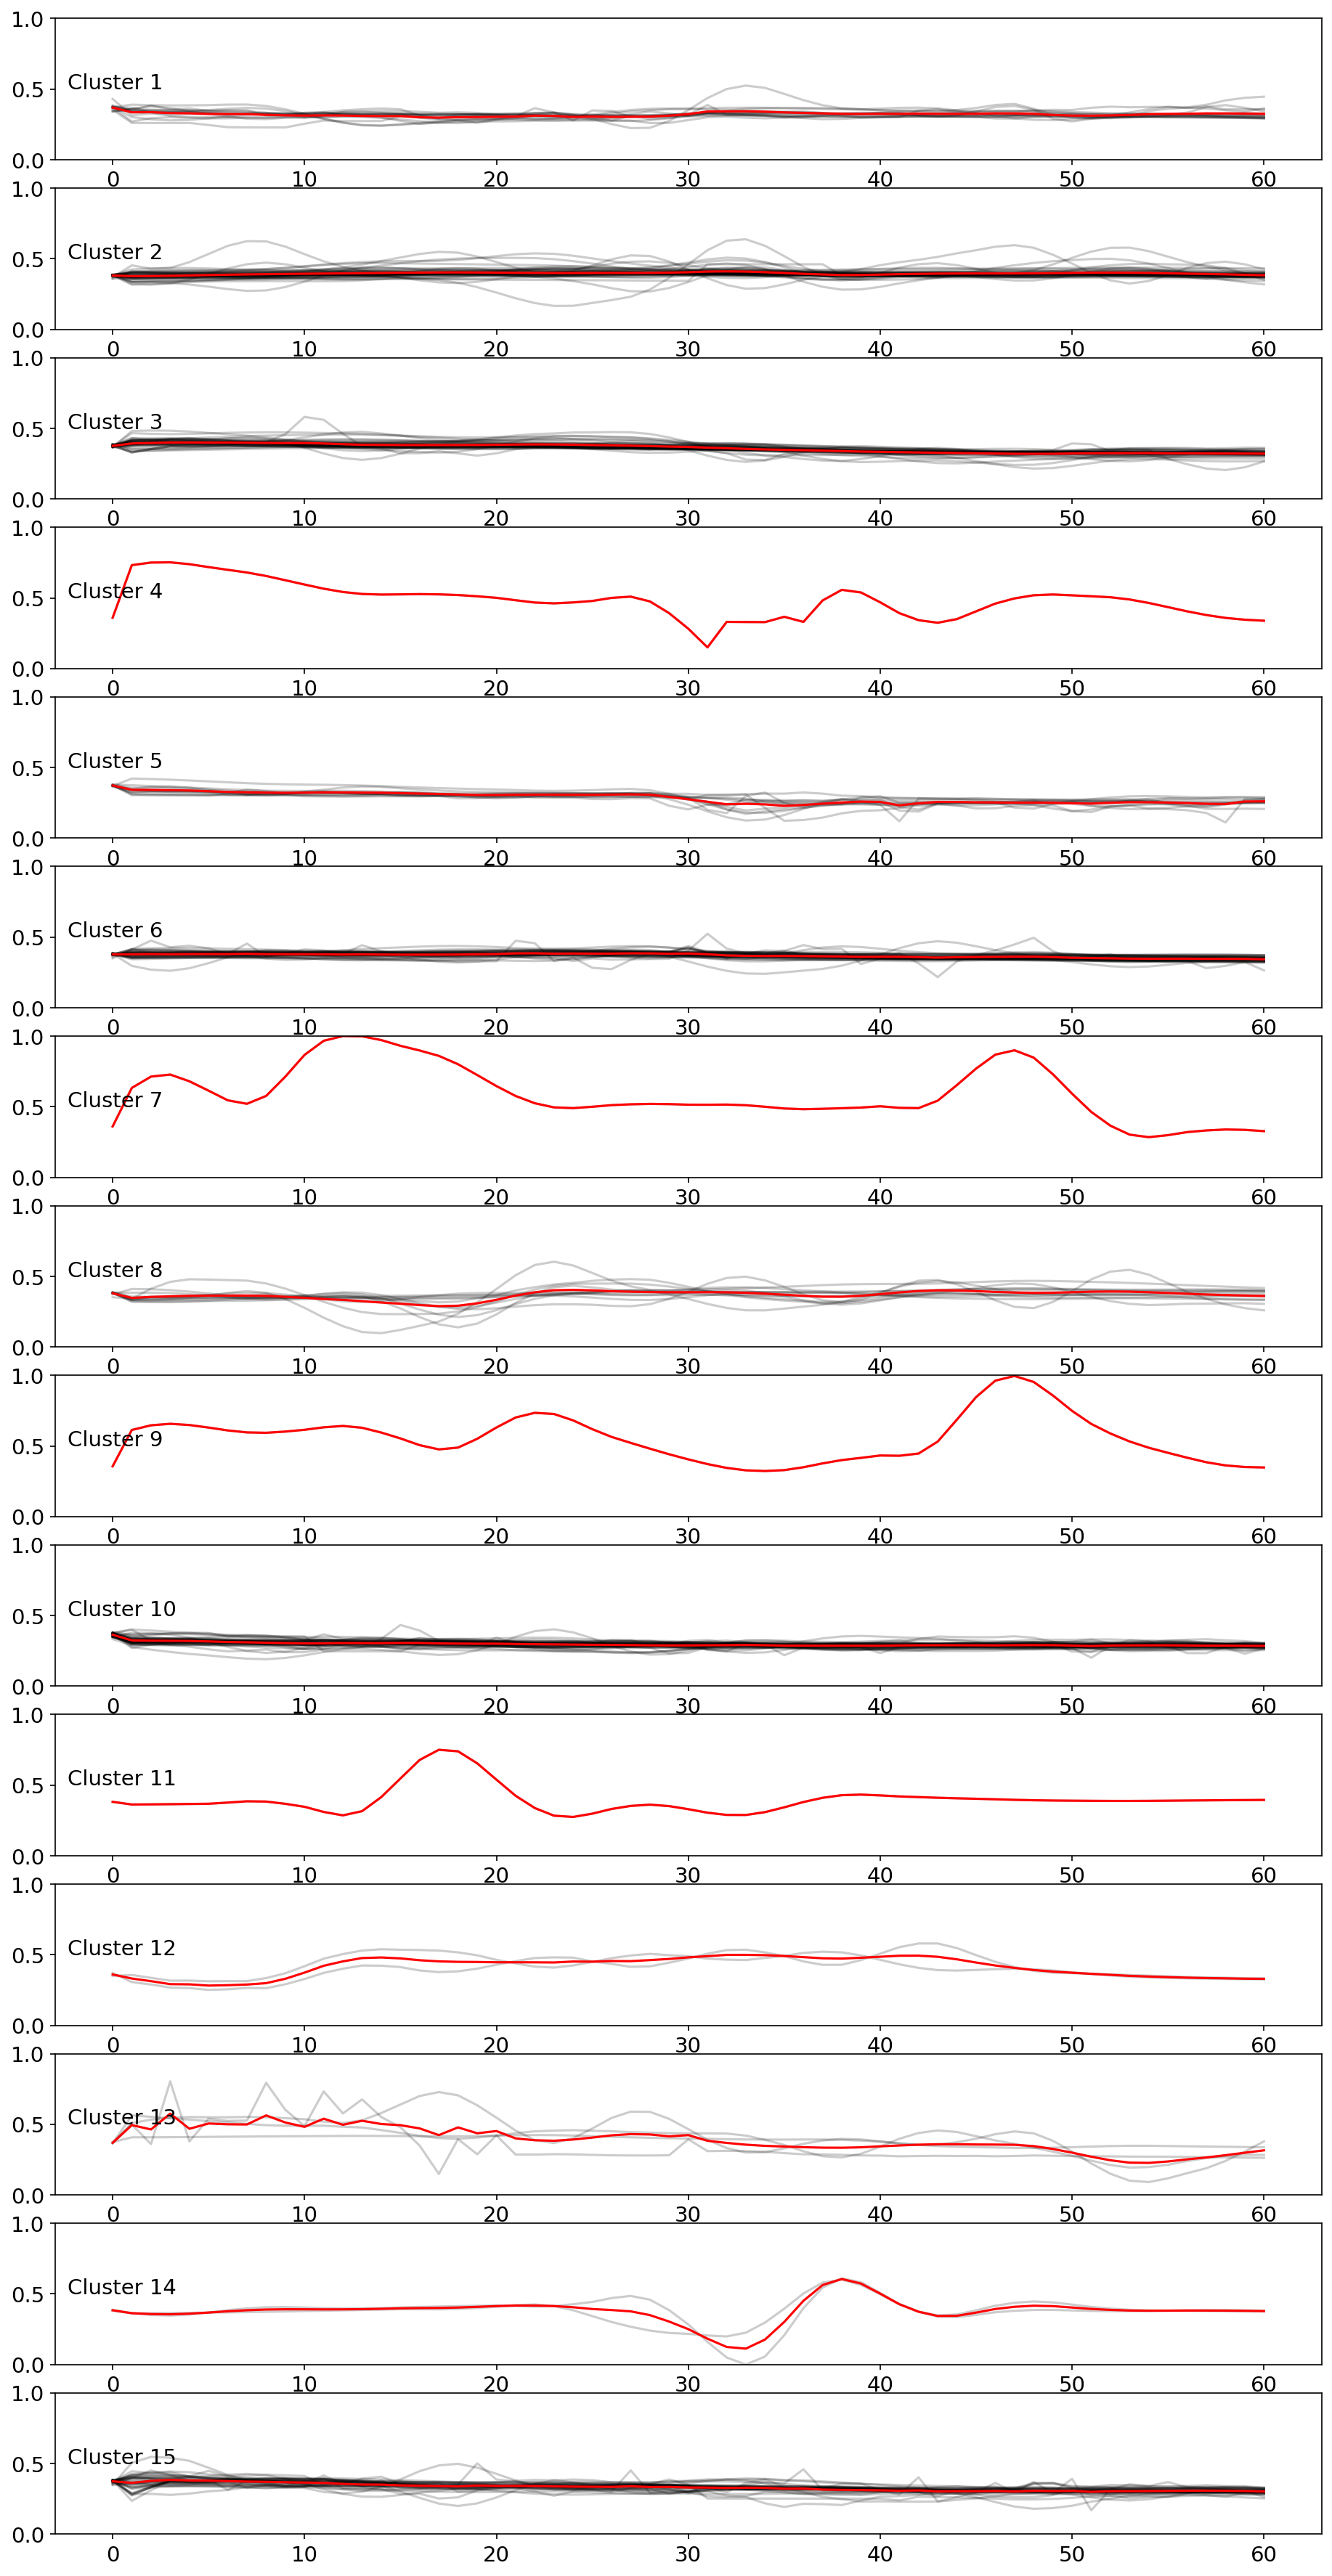

In [20]:
# Population Growth

mpl.rcParams["figure.figsize"] = (15,30) #change figure size, (x, y)
y_pred_X_euclideanKM_population_growth = euclideanKMeans(15, seed, X_train_population_growth)

Euclidean k-means
0.006 --> 0.004 --> 0.004 --> 
Euclidean k-means Chart


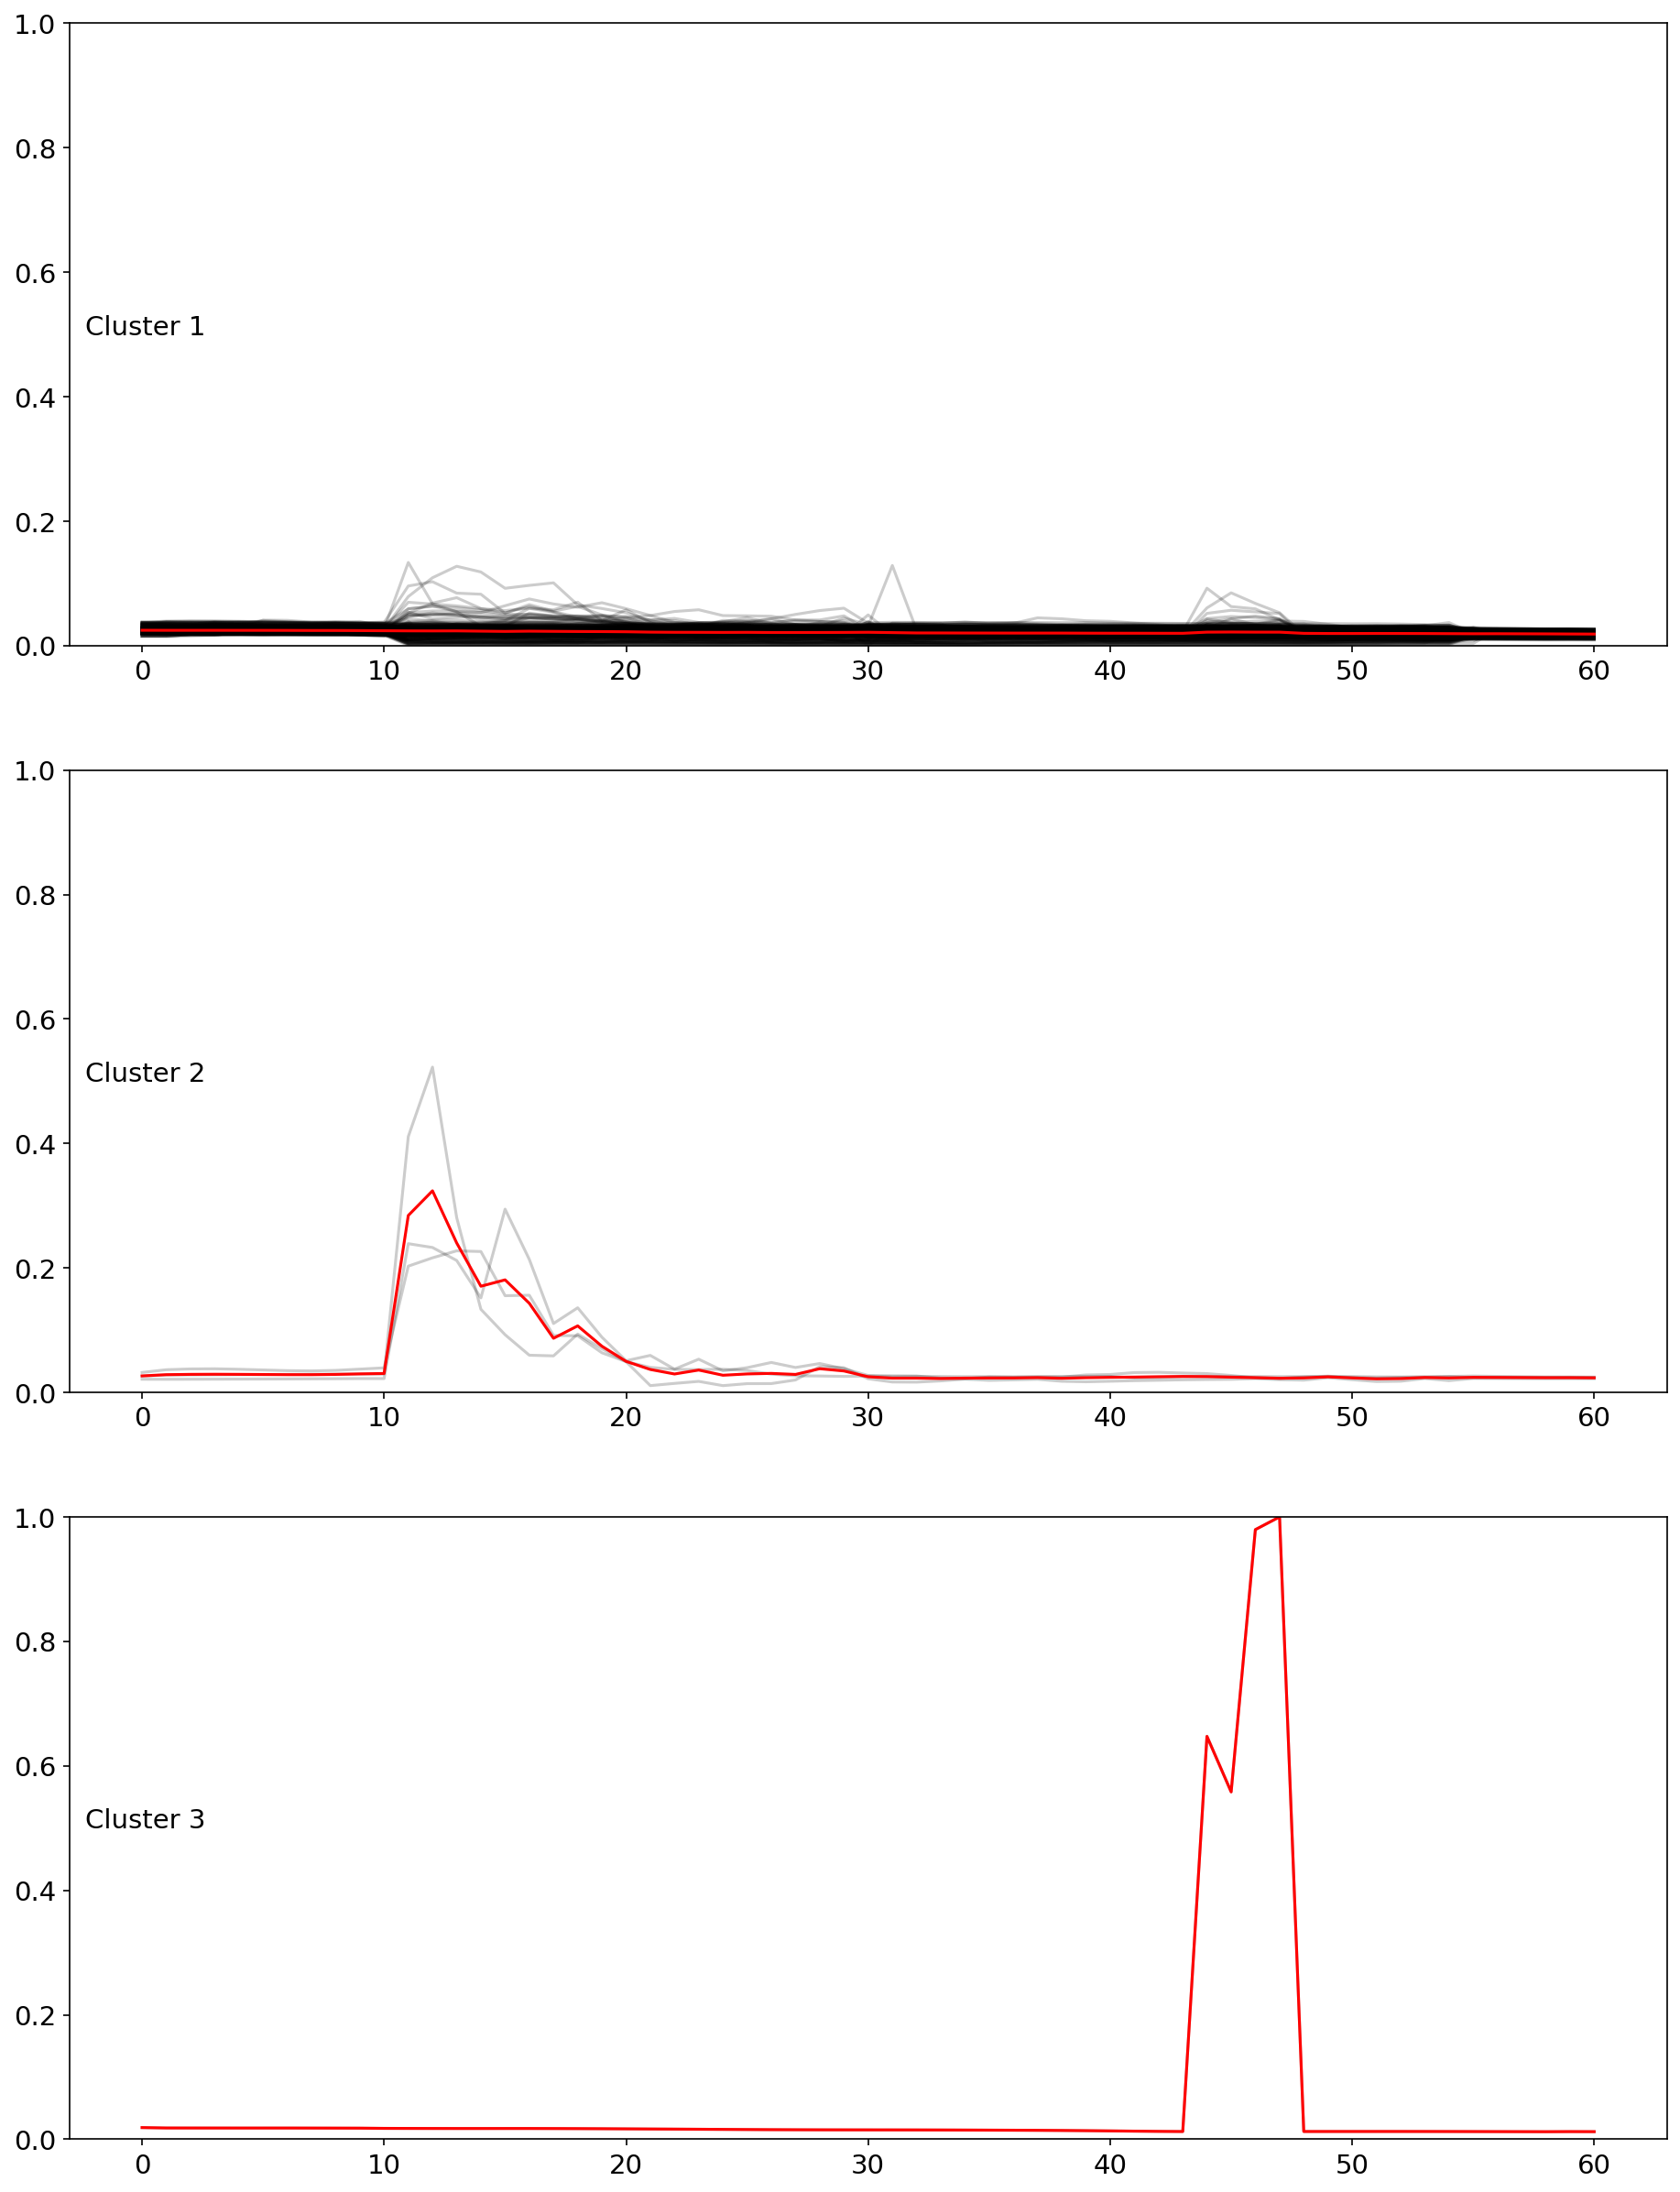

In [21]:
mpl.rcParams["figure.figsize"] = (15,20) #change figure size, (x, y)
y_pred_X_euclideanKM_co2_intensity = euclideanKMeans(3, seed, X_train_co2_intensity)

Euclidean k-means
0.110 --> 0.078 --> 0.073 --> 0.070 --> 0.069 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 0.068 --> 
Euclidean k-means Chart


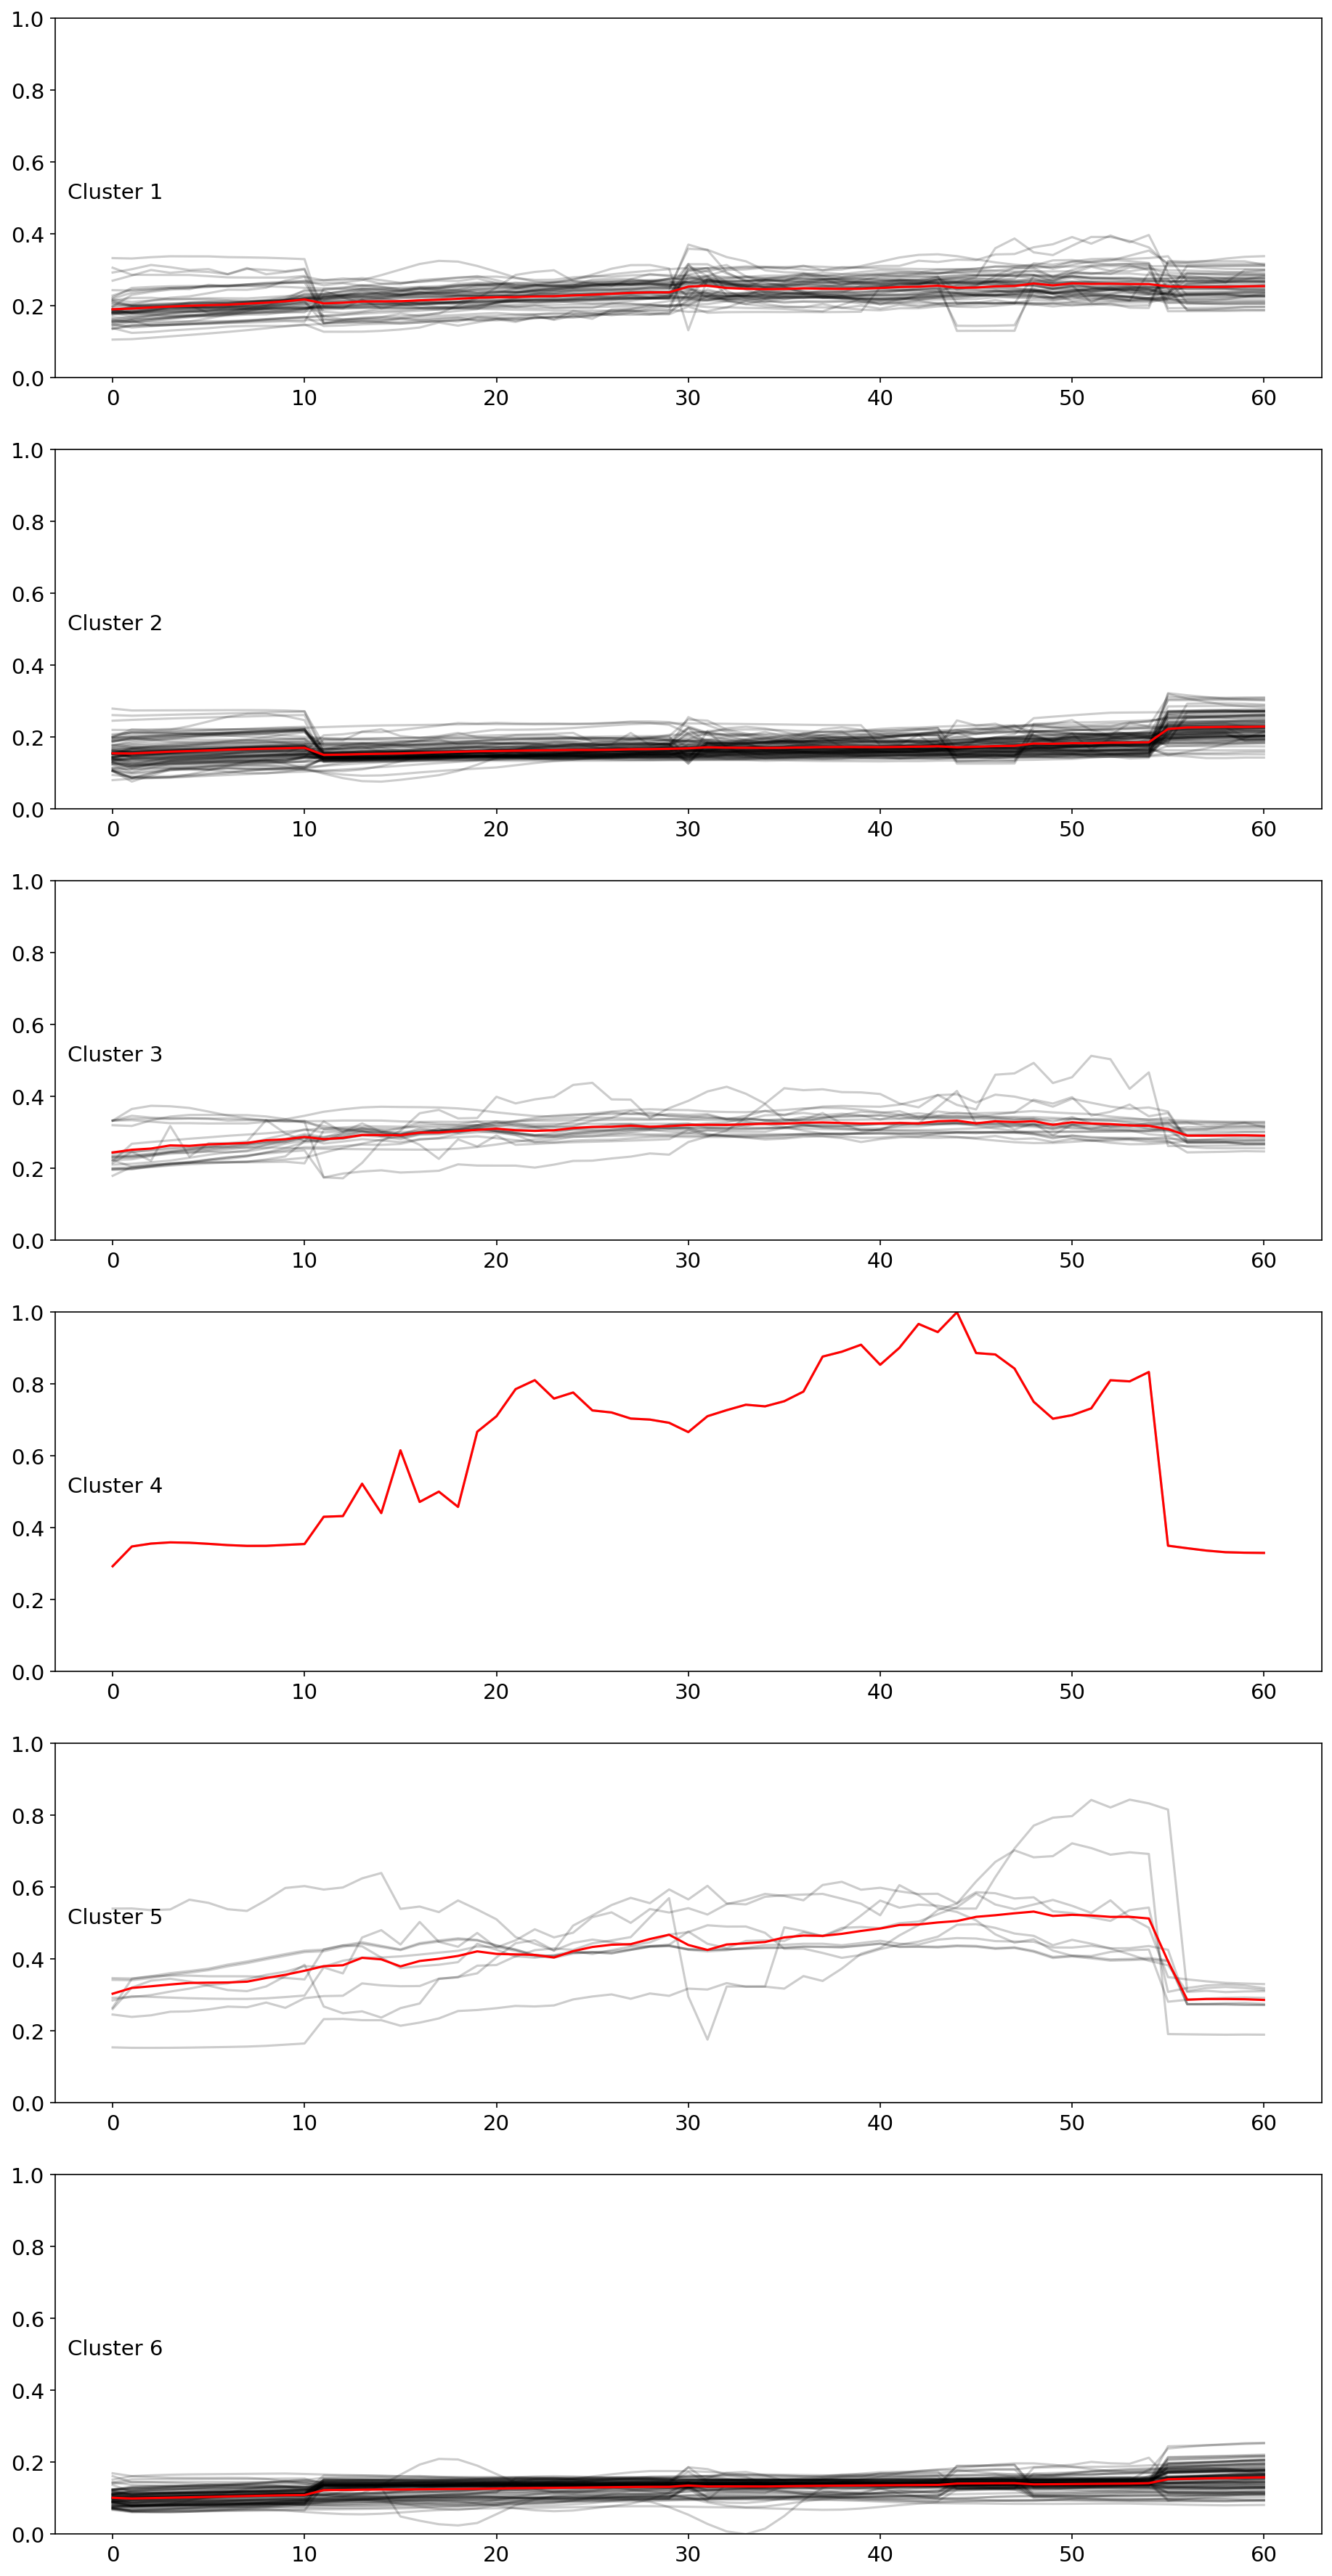

In [22]:
mpl.rcParams["figure.figsize"] = (15,30) #change figure size, (x, y)
y_pred_X_euclideanKM_energy_use = euclideanKMeans(6, seed, X_train_energy_use)

## EDA for Clustering

In [23]:
y_pred_X_euclideanKM_co2_intensity

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [24]:
# get all cluster name
cluster_result_euclideanKM_co2_intensity = mergeClusterNames(y_pred_X_euclideanKM_co2_intensity, country_name)
cluster_result_euclideanKM_co2_intensity

cluster
Aruba                              0
Africa Eastern and Southern        0
Afghanistan                        0
Africa Western and Central         0
Angola                             0
...                              ...
Samoa                              0
Yemen, Rep.                        0
South Africa                       0
Zambia                             0
Zimbabwe                           0

[255 rows x 1 columns]

In [25]:
# co2 intensity has 3 clusters 
cluster_result_euclideanKM_co2_intensity_1 = getSingleCluster(cluster_result_euclideanKM_co2_intensity, 1)
cluster_result_euclideanKM_co2_intensity_2 = getSingleCluster(cluster_result_euclideanKM_co2_intensity, 2)
cluster_result_euclideanKM_co2_intensity_3 = getSingleCluster(cluster_result_euclideanKM_co2_intensity, 3)

In [26]:
# select cluster 2 for EDA
cluster_name_co2_intensity_2 = cluster_result_euclideanKM_co2_intensity_2.index.tolist()

def get_df_viz(df_source, indicatorName):
    df_viz = df_source.reset_index()
    df_viz = df_viz[df_viz['Indicator Name']==indicatorName]
    df_viz = df_viz[df_viz['Country Name'].isin(cluster_name_co2_intensity_2)]
    return df_viz
    
df_viz_co2_intensity = get_df_viz(df_worldbank_transposed, feat_list[3])
df_viz_co2_intensity.drop(columns=['index', 'Indicator Name'], inplace=True)
df_viz_co2_intensity

0            Country Name       1960       1961       1962       1963  \
43   United Arab Emirates  0.0320919   0.036478  0.0377608  0.0379856   
158     Brunei Darussalam  0.0263559  0.0280589  0.0281678  0.0283258   
878                  Oman  0.0212102  0.0211171  0.0212207  0.0213255   

0         1964       1965       1966       1967       1968  ...       2011  \
43   0.0372122  0.0361318  0.0350155  0.0345996  0.0354258  ...  0.0250604   
158  0.0285451  0.0287986  0.0290503  0.0292705  0.0294726  ...  0.0175461   
878  0.0214362  0.0215537  0.0216953  0.0218655  0.0220651  ...  0.0230657   

0         2012       2013       2014       2015       2016       2017  \
43   0.0249087  0.0255136  0.0252878  0.0238228  0.0240557  0.0241289   
158  0.0180461  0.0223693  0.0190115  0.0224848  0.0223261  0.0221792   
878  0.0240163  0.0241966    0.02569  0.0263993   0.025831  0.0253655   

0         2018       2019       2020  
43   0.0241202  0.0241638  0.0238982  
158  0.0220289  0.0221384  0.0219978  
878  0.0249652  0.0249063  0.0246629  

[3 rows x 62 columns]

In [27]:
#
# pivot function 3
#

# function to slice out country from the df
# and transpose the data to become year-column format
# specially design for clustering function
def get_pivot_data_year_column_cluster(df, country_name, indicatorName, columnsToDrop=[]):
    df_country = df[df['Country Name'] == country_name].copy()
    if len(df_country) == 0:
        return 0 # country name does not exist
    
    # get ready to transpose
    df_country.drop(columns=columnsToDrop, inplace=True)
    df_country.reset_index(inplace=True, drop=True) 
    
    # transpose
    df_country = df_country.transpose()
    
    # rename header
    df_country.rename(columns={0: f'{indicatorName}'}, inplace=True)
    df_country.reset_index(inplace=True)
    df_country.rename(columns={0: 'Year'}, inplace=True)
    
    # reset year column type to int and others to float
    df_country['Year'] = df_country['Year'].astype('int32')
    headers = df_country.columns.tolist()[1:] # all headers except 'Year'
    for h in headers:
        df_country[h] = df_country[h].apply(pd.to_numeric, errors='coerce')
    
    # add country name column back and reposition it to first column
    df_country['Country Name'] = country_name
    cols = df_country.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_country = df_country[cols]
        
    return df_country

In [28]:
#
# Transpose dataset
#

# define countries, years and columns
countries = df_viz_co2_intensity['Country Name'].unique().tolist()
columnsName = ['Country Name', 'Year', 'CO2 intensity (kg per kg of oil equivalent energy use)']

# loop the entire dataset and transpose all countries
df_viz_co2_intensity_transposed = pd.DataFrame([], columns=columnsName)
for country in countries:
    df_temp = get_pivot_data_year_column_cluster(df_viz_co2_intensity, country, columnsName[2], ['Country Name'])
    df_viz_co2_intensity_transposed = pd.concat([df_viz_co2_intensity_transposed, df_temp], axis=0)#, ignore_index=True)
    
# final result
df_viz_co2_intensity_transposed

Country Name  Year  \
0   United Arab Emirates  1960   
1   United Arab Emirates  1961   
2   United Arab Emirates  1962   
3   United Arab Emirates  1963   
4   United Arab Emirates  1964   
..                   ...   ...   
56                  Oman  2016   
57                  Oman  2017   
58                  Oman  2018   
59                  Oman  2019   
60                  Oman  2020   

    CO2 intensity (kg per kg of oil equivalent energy use)  
0                                            0.032092       
1                                            0.036478       
2                                            0.037761       
3                                            0.037986       
4                                            0.037212       
..                                                ...       
56                                           0.025831       
57                                           0.025365       
58                                           0.024965       
59                                           0.024906       
60                                           0.024663       

[183 rows x 3 columns]

In [29]:
fig = px.line(df_viz_co2_intensity_transposed, 
              x="Year", 
              y=columnsName[2], 
              color='Country Name')
fig.show()